### Assignment 2

#### Submit your assignment as .ipynb

In [1]:
import math
from enum import Enum
from scipy.interpolate import CubicSpline
import numpy as np
import matplotlib.pyplot as plt
import bisect

#### Exercise 1.

Implement a trinomial tree that takes the below signature:

In [27]:
class PayoffType(str, Enum):
    Call = 'Call'
    Put = 'Put'


class EuropeanOption():
    def __init__(self, expiry, strike, payoffType):
        self.expiry = expiry
        self.strike = strike
        self.payoffType = payoffType
    def payoff(self, S):
        if self.payoffType == PayoffType.Call:
            return max(S - self.strike, 0)
        elif self.payoffType == PayoffType.Put:
            return max(self.strike - S, 0)
        else:
            raise Exception("payoffType not supported: ", self.payoffType)
    def valueAtNode(self, t, S, continuation):
        if continuation == None:
            return self.payoff(S)
        else:
            return continuation


def cal_lmda(S, K, vol, t, trade, n, tolerance = 1e-8, init_lmda = math.sqrt(3)):
    lmda_min, lmda_max = 1, init_lmda*1.5  # Set a range for lambda
    lmda_cal = init_lmda
    node_dif = float('inf')
    iterations = 0

    while abs(node_dif) > tolerance:
        # Calculate the up and down factors
        u = math.exp(lmda_cal * vol * math.sqrt(t))

        # Build the final layer of the tree
        vs = [trade.payoff(S * u ** (n - i)) for i in range(2*n+1)]

        # Find the node closest to the strike price K
        closest_node = min(vs, key=lambda x: abs(x-K))
        node_dif = closest_node - K

        # Adjust lambda
        if node_dif > 0:
            lmda_max = lmda_cal
        else:
            lmda_min = lmda_cal

        lmda_cal = (lmda_max + lmda_min) / 2  # New lambda is the midpoint
        iterations += 1

    return lmda_cal


def trinomialPricerAnchor(S, r, q, vol, trade, n, K):
    t = trade.expiry / n
    lmda = cal_lmda(S, K, vol, t, trade, n)
    
    u = math.exp(lmda * vol * math.sqrt(t))
    mu = r - q
    pu = 1 / 2 / lmda / lmda + (mu - vol * vol / 2) / 2 / lmda / vol * math.sqrt(t)
    pd = 1 / 2 / lmda / lmda - (mu - vol * vol / 2) / 2 / lmda / vol * math.sqrt(t)
    pm = 1 - pu - pd

    # set up the last time slice, there are 2n+1 nodes at the last time slice
    # counting from the top, the i-th node's stock price is S * u^(n - i), i from 0 to n+1
    vs = [trade.payoff(S * u ** (n - i)) for i in range(2*n + 1)]
    # iterate backward
    for i in range(n - 1, -1, -1):
        # calculate the value of each node at time slide i, there are i nodes
        for j in range(2*i + 1):
            nodeS = S * u ** (i - j)
            continuation = math.exp(-r * t) * (vs[j] * pu +  + vs[j+1] * pm + vs[j+2] * pd)
            vs[j] = trade.valueAtNode(t * i, nodeS, continuation)
    return vs[0]

In [5]:
def cnorm(x):
    return (1.0 + math.erf(x / math.sqrt(2.0))) / 2.0
def bsPrice(S, r, vol, payoffType, K, T):
    fwd = S * math.exp(r * T)
    stdev = vol * math.sqrt(T)
    d1 = math.log(fwd / K) / stdev + stdev / 2
    d2 = d1 - stdev
    if payoffType == PayoffType.Call:
        return math.exp(-r * T) * (fwd * cnorm(d1) - cnorm(d2) * K)
    elif payoffType == PayoffType.Put:
        return math.exp(-r * T) * (K * cnorm(-d2) - cnorm(-d1) * fwd)
    else:
        raise Exception("not supported payoff type", payoffType)

Instead of taking the parameter $\lambda$ in our example code, this function takes a discontinuity K and anchors a tree node to K by tuning $\lambda$ inside the pricer.
Note that there are many ways to adjust $\lambda$, one example is to construct the tree with $\lambda = \sqrt{3}$ first, find the node closest to $K$, then adjust $\lambda$ such that the node falls on $K$, but you are free to define your own way to achieve this.

Plot the pricing errors of this trinomial tree pricer with the market and strike below, for number of tree steps from 10 to 300 (similar to our binomial tree test cases).
Use a European Call option and a Binary Call option as test trades.

In [28]:
K = 105
S, r, vol = 100, 0.01, 0.2

In [8]:
bsPrc = bsPrice(S, r, vol, PayoffType.Call, K, 1)

In [29]:
triErrs = [math.log(abs(trinomialPricerAnchor(S, r, 0, vol, EuropeanOption(1, K, PayoffType.Call), i, K) - bsPrc)) for i in range(10,301)]

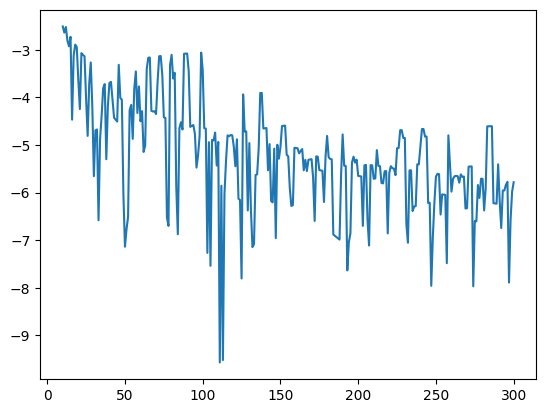

In [30]:
plt.plot(range(10,301), triErrs)
plt.show()

#### Exercise 2.

Assuming forward delta convention, implement below function ```strikeFromdelta``` that calculates the strike from a given delta.
You may use the ```fwdDelta``` function below. Test with below:

S, r, q, T, vol, delta, payoffType = 100, 0.1, 0, 1, 0.1, 0.25, PayoffType.Put

In [ ]:
class PayoffType(Enum):
    Call = 0
    Put = 1
def cnorm(x):
    return (1.0 + math.erf(x / math.sqrt(2.0))) / 2.0

def fwdDelta(fwd, stdev, strike, payoffType):
    d1 = math.log(fwd / strike) / stdev + stdev / 2
    if payoffType == PayoffType.Call:
        return cnorm(d1)
    elif payoffType == PayoffType.Put:
        return -cnorm(-d1)
    else:
        raise Exception("not supported payoff type", payoffType)

# solve for the K such that Delta(S, T, K, vol) = delta, assuming forward delta convention
def strikeFromDelta(S, r, q, T, vol, delta, payoffType):
    strike = 0
    # your implementation here
    return strike


#### Exercise 3.

Implement ```smilefromMarks``` function below, it take the time to maturity $T$, current stop price $S$, risk free and dividend rate $r$ and $q$,
ATM volatility, BF25, RR25, BF10, RR10 quotes, returns a CubicSpline interpolated smile for this pillar. We assume ATM forward convention. 
You may use the Smile class provided below.   

In [ ]:
class Smile:
    def __init__(self, strikes, vols):
        # add additional point on the right to avoid arbitrage
        self.strikes = strikes  + [1.1*strikes[-1] - 0.1*strikes[-2]]
        self.vols = vols + [vols[-1] + (vols[-1]-vols[-2])/10]
        self.cs = CubicSpline(strikes, vols, bc_type=((1, 0.0), (1, 0.0)), extrapolate=True)
    def Vol(self, k):
        if k < self.strikes[0]:  # scipy cubicspline bc_type confusing, extrapolate by ourselfs
            return self.vols[0]
        if k > self.strikes[-1]:
            return self.vols[-1]
        else:
            return self.cs(k)

def smileFromMarks(T, S, r, q, atmvol, bf25, rr25, bf10, rr10):
    # your implementation here
    strikes = ...
    vols = ...
    return Smile(strikes, vols)

With ```smileFromMarks```, we can prepare our implied volatility surface from input marks.

In [ ]:
class ImpliedVol:
    def __init__(self, ts, smiles):
        self.ts = ts
        self.smiles = smiles
    # linear interpolation in variance, along the strike line
    def Vol(self, t, k):
        # locate the interval t is in
        pos = bisect.bisect_left(self.ts, t)
        # if t is on or in front of first pillar,
        if pos == 0:
            return self.smiles[0].Vol(k)
        if pos >= len(self.ts):
            return self.smiles[-1].Vol(k)
        else:  # in between two brackets
            prevVol, prevT = self.smiles[pos-1].Vol(k), self.ts[pos-1]
            nextVol, nextT = self.smiles[pos].Vol(k), self.ts[pos]
            w = (nextT - t) / (nextT - prevT)
            prevVar = prevVol * prevVol * prevT
            nextVar = nextVol * nextVol * nextT
            return  math.sqrt((w * prevVar + (1-w) * nextVar)/t)
        return
    def dVoldK(self, t, k):
        return (self.Vol(t, k+0.01) - self.Vol(t, k-0.01)) / 0.02
    def dVoldT(self, t, k):
        return (self.Vol(t+0.005, k) - self.Vol(t, k)) / 0.005
    def dVol2dK2(self, t, k):
        return (self.Vol(t, k+0.01) + self.Vol(t, k-0.01) - 2*self.Vol(t, k)) / 0.0001

Plot the test implied volatility surface using below test functions.

In [ ]:
def createTestImpliedVol(S, r, q):
    pillars = [0.02, 0.04, 0.06, 0.08, 0.16, 0.25, 0.75, 1.0, 1.5, 2, 3, 5] # in year
    atmvols = [0.155, 0.1395, 0.1304, 0.1280, 0.1230, 0.1230, 0.1265, 0.1290, 0.1313, 0.1318, 0.1313, 0.1305, 0.1295]
    bf25s = [0.0016, 0.0016, 0.0021, 0.0028, 0.0034, 0.0043, 0.0055, 0.0058, 0.0060, 0.0055, 0.0054, 0.0050, 0.0045, 0.0043]
    rr25s = [-0.0065, -0.0110, -0.0143, -0.0180, -0.0238, -0.0288, -0.0331, -0.0344, -0.0349, -0.0340, -0.0335, -0.0330, -0.0330]
    bf10s = [0.0050, 0.0050, 0.0067, 0.0088, 0.0111, 0.0144, 0.0190, 0.0201, 0.0204, 0.0190, 0.0186, 0.0172, 0.0155, 0.0148]
    rr10s = [-0.0111, -0.0187, -0.0248, -0.0315, -0.0439, -0.0518, -0.0627, -0.0652, -0.0662, -0.0646, -0.0636, -0.0627, -0.0627]
    smiles = [smileFromMarks(pillars[i], S, r, q, atmvols[i], bf25s[i], rr25s[i], bf10s[i], rr10s[i]) for i in range(len(pillars))]
    return ImpliedVol(pillars, smiles)

def plotTestImpliedVolSurface():
    S, r, q = 1.25805, 0.01, 0.003
    iv = createTestImpliedVol(S, r, q)
    tStart, tEnd = 0.02, 0.5
    ts = np.arange(tStart, tEnd, 0.1)
    fwdEnd = S*math.exp((r-q)*tEnd)
    kmin = strikeFromDelta(S, r, q, tEnd, iv.Vol(tEnd, fwdEnd), 0.05, PayoffType.Put)
    kmax = strikeFromDelta(S, r, q, tEnd, iv.Vol(tEnd, fwdEnd), 0.05, PayoffType.Call)
    ks = np.arange(kmin, kmax, 0.01)

    vs = np.ndarray((len(ts), len(ks)))
    for i in range(len(ts)):
        for j in range(len(ks)):
            vs[i, j] = iv.Vol(ts[i], ks[j])
    hf = plt.figure()
    ha = hf.add_subplot(111, projection='3d')
    X, Y = np.meshgrid(ks, ts)
    ha.plot_surface(X, Y, vs)
    plt.show()
plotTestImpliedVolSurface()